**Задание**  
Компания тестирует изменение дизайна сайта:  

Группа A (контрольная): Белый фон (текущая версия).  
Группа B (тестовая): Черный фон (новая версия).  

Цель: Проверить, увеличивает ли новый фон (черный) вовлеченность пользователей (время на сайте, конверсия).  

Описание столбцов представлено ниже:  
- User ID (Идентификатор пользователя): Уникальный идентификатор каждого пользователя.  
- Group (Группа): Содержит контрольную группу (A) и тестовую группу (B).  
- Time Spent (Время на сайте): Общее количество времени (в секундах), которое пользователь провел на сайте.  
- Conversion (Конверсия): Показывает, выполнил ли пользователь целевое действие («Yes»/«No»).  

**Я решил усложнить данное задание, сгенерировав столбец avg_session_time (среднее время сессии) для того, чтобы охватить все ключевые типы метрик.** 

In [342]:
# блок импортов
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import  norm, shapiro, levene, ttest_ind, chi2_contingency, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest, confint_proportions_2indep
from statsmodels.stats.weightstats import CompareMeans
 

**1) Первичный осмотр данных (EDA)**

In [343]:
data = pd.read_csv('ab_testing.csv', delimiter=';')
print(' SHAPE '.center(70, '-'))
print(data.shape)
print(' DATA TYPES '.center(70, '-'))
print(data.dtypes)
print(' NULL VALUES '.center(70, '-'))
print(data.isnull().sum().to_string())

data.describe(include='all')

------------------------------- SHAPE --------------------------------
(5000, 4)
----------------------------- DATA TYPES -----------------------------
User ID        int64
Group         object
Time Spent     int64
Conversion    object
dtype: object
---------------------------- NULL VALUES -----------------------------
User ID       0
Group         0
Time Spent    0
Conversion    0


,User ID,Group,Time Spent,Conversion
count,5000.000000,5000,5000.000000,5000
unique,NaN,2,NaN,2
top,NaN,A,NaN,No
freq,NaN,2519,NaN,4515
mean,14925.159000,NaN,242.512600,NaN
std,2869.153773,NaN,118.254153,NaN
min,10001.000000,NaN,40.000000,NaN
25%,12456.250000,NaN,137.000000,NaN
50%,14858.500000,NaN,243.000000,NaN
75%,17379.750000,NaN,346.000000,NaN


In [344]:
data.head()

,User ID,Group,Time Spent,Conversion
0,14292,B,424,No
1,11682,A,342,No
2,19825,A,396,No
3,16080,B,318,No
4,18851,A,338,Yes


<Axes: ylabel='Time Spent'>

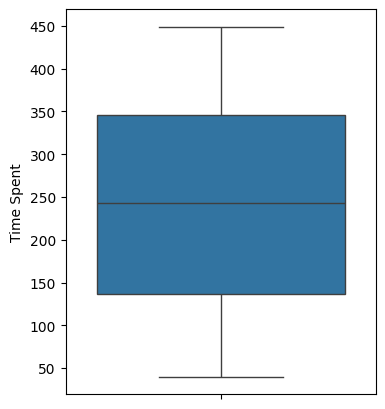

In [345]:
plt.figure(figsize=(4, 5))
sns.boxplot(data['Time Spent'])

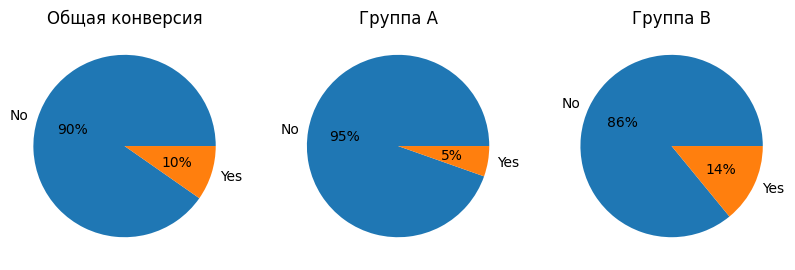

In [346]:
plt.figure(figsize=(10,6))
plt.subplot(1,3,1)
data['Conversion'].value_counts().plot(kind='pie', autopct='%1.0f%%')
plt.axis('off')
plt.title('Общая конверсия')
plt.subplot(1,3,2)
data[data['Group'] == 'A']['Conversion'].value_counts().plot(kind='pie', autopct='%1.0f%%')
plt.axis('off')
plt.title('Группа А')
plt.subplot(1,3,3)
data[data['Group'] == 'B']['Conversion'].value_counts().plot(kind='pie', autopct='%1.0f%%')
plt.axis('off')
plt.title('Группа B')
plt.show()

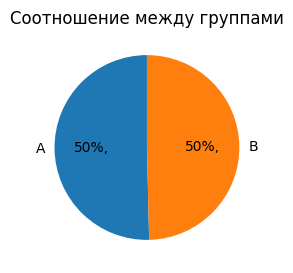

In [347]:
plt.figure(figsize=(3,3))
data['Group'].value_counts().plot(kind='pie', autopct='%1.0f%%,', startangle=90)
plt.title('Соотношение между группами')
plt.axis('off')
plt.show()

<Figure size 1000x600 with 0 Axes>

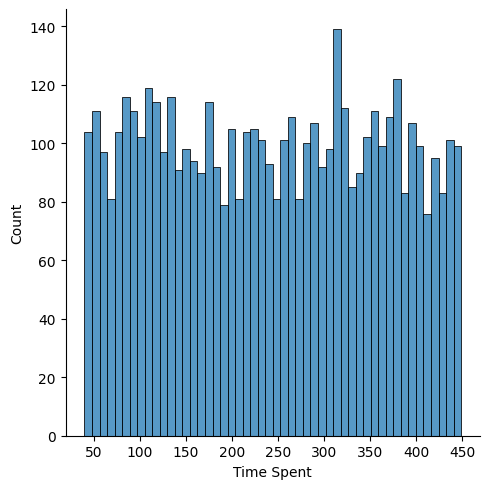

In [348]:
plt.figure(figsize=(10,6)) # проверка распределения
sns.displot(data, x='Time Spent', bins=50)

**2) Модификация дата фрейма**

In [349]:
# генерация столбца avg_session_time
# параметры генерации
n = len(data)  # определяем количество строк
mean_session = 300  # Среднее время сессии в секундах
std_session = 50     # Стандартное отклонение

# Генерируем данные с нормальным распределением
avg_session_time = np.random.normal(loc=mean_session, scale=std_session, size=n)
avg_session_time = np.clip(avg_session_time, a_min=10, a_max=600) # удаляем выбросы
data['avg_session_time'] = np.round(session_duration).astype(int) # округляем до целых секунд

# преобразуем столбец Conversion для более удобной обработки значений
data['Conversion'] = data['Conversion'].str.strip().str.lower().map({'yes': 1, 'no': 0}) # data['Conversion'] содержал спец символы
data.head()


,User ID,Group,Time Spent,Conversion,avg_session_time
0,14292,B,424,0,238
1,11682,A,342,0,328
2,19825,A,396,0,305
3,16080,B,318,0,269
4,18851,A,338,1,326


**3) Анализ метрик, выбор теста** 
- conversion  
    Бинарная метрика, для демонстрации навыков я применю χ² и Z-тест.  
    Оба теста должны показать одинаковые результаты (математически эквивалентны в условиях данного эксперимента)
- time_spent  
    Непрерывная непараметрическая метрика (проверю тестом Шапиро-Уилка) - U-тест Манна-Уитни
- avg_session_time  
    Непрерывная метрика с нормальным распределением (изначально генерировал в соответствии с нормальным распределением, проверю тестом Шапиро-Уилка)
  

**4) Формулировка гипотез** 
- Нулевая (H₀):
"Черный фон не повлиял на поведение пользователей – различия между группами случайны"

- Альтернативная (H₁):
"Черный фон изменил поведение пользователей (разница статистически значима)"

**5) Z-тест**

In [350]:
alpha = 0.05  # исходный уровень значимости
significant_level = alpha / 3  # с поправкой Бонферрони

successes = [
    data[data['Group'] == 'B']['Conversion'].sum(),  # Группа B
    data[data['Group'] == 'A']['Conversion'].sum()  # Группа A
]

nobs = [
    len(data[data['Group'] == 'B']),  # Размер группы B
    len(data[data['Group'] == 'A'])   # Размер группы A
]

p_B = successes[0] / nobs[0]
p_A = successes[1] / nobs[1]

diff = p_B - p_A

if ((nobs[0] * p_B > 5 and nobs[0] * (1 - p_B) > 5) and
    (nobs[1] * p_A > 5 and nobs[1] * (1 - p_A) > 5)):
    print('Условия для проведения теста выполнены')
else:
    print('Условия для проведения теста не выполнены')

Условия для проведения теста выполнены


In [322]:
z_stat, p_value = proportions_ztest(successes, nobs, alternative='two-sided')

ci_low, ci_high = confint_proportions_2indep(
    successes[0], nobs[0],  # Группа B
    successes[1], nobs[1]   # Группа A
)

# Вывод
print(f'Z-статистика = {z_stat:.2f}')
print(f'p-value = {p_value:.4f}')
print(f'Разница: {diff:.2%} (B - A)')
print(f"95% ДИ разницы: [{ci_low:.2%}, {ci_high:.2%}]")

if p_value < significant_level:
    print(f'Отвергаем H₀: B лучше A на {diff:.2%} (ДИ: [{ci_low:.2%}, {ci_high:.2%}])')
else:
    print('Нулевая гипотеза подтверждена')
print(
    "Результат A/B-теста:\n"
    f"- Конверсия: A = {p_A:.1%}, B = {p_B:.1%}\n"
    f"- Прирост конверсии в B: +{diff:.2%} (95% ДИ: {ci_low:.2%}, {ci_high:.2%})\n"
    "Вывод: группа B (черный фон) достоверно увеличивает конверсию."
)

Z-статистика = 10.35
p-value = 0.0000
Разница: 8.67% (B - A)
95% ДИ разницы: [7.05%, 10.31%]
Отвергаем H₀: B лучше A на 8.67% (ДИ: [7.05%, 10.31%])
Результат A/B-теста:
- Конверсия: A = 5.4%, B = 14.1%
- Прирост конверсии в B: +8.67% (95% ДИ: 7.05%, 10.31%)
Вывод: группа B (чёрный фон) достоверно увеличивает конверсию.


**6) χ²-тест**

In [351]:
# Создаем таблицу сопряженности 2x2

contingency_table = np.array([
    [successes[0], nobs[0] - successes[0]], # Группа B
    [successes[1], nobs[1] - successes[1]] # Группа A
    ])

chi2_stat, p_value, _, _ = chi2_contingency(contingency_table)

ci_low, ci_upp = confint_proportions_2indep(
    count1=successes[0], nobs1=nobs[0],
    count2=successes[1], nobs2=nobs[1]
)


print(f'χ²-статистика = {chi2_stat:.2f}')
print(f'p-value = {p_value:.4f}')
print(f'Разница: {diff:.2%} (B - A)')
print(f"95% ДИ: [{ci_low:.2%}, {ci_high:.2%}]")

if p_value < significant_level:
    print(f'Отвергаем H₀: B лучше A на {diff:.2%} (ДИ: [{ci_low:.2%}, {ci_high:.2%}])')
else:
    print('Нулевая гипотеза подтверждена')
print(
    "Результат A/B-теста:\n"
    f"- Конверсия: A = {p_A:.1%}, B = {p_B:.1%}\n"
    f"- Прирост конверсии в B: +{diff:.2%} (95% ДИ: {ci_low:.2%}, {ci_high:.2%})\n"
    "Вывод: группа B (черный фон) достоверно увеличивает конверсию."
)

χ²-статистика = 106.23
p-value = 0.0000
Разница: 8.67% (B - A)
95% ДИ: [7.05%, 10.31%]
Отвергаем H₀: B лучше A на 8.67% (ДИ: [7.05%, 10.31%])
Результат A/B-теста:
- Конверсия: A = 5.4%, B = 14.1%
- Прирост конверсии в B: +8.67% (95% ДИ: 7.05%, 10.31%)
Вывод: группа B (черный фон) достоверно увеличивает конверсию.


Нет никакой разницы в результатах с Z - тестом поскольку χ² для таблицы 2×2 математически эквивалентен Z-тесту для двух пропорций

**7) t-test**  
H₀ - средние значения переменной avg_session_time равны между группами  
H₁ - средние значения переменной avg_session_time отличаются между группами

<Figure size 1000x600 with 0 Axes>

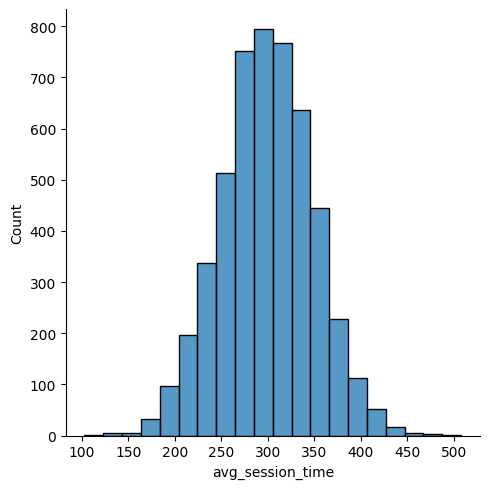

In [324]:
plt.figure(figsize=(10,6)) # проверка распределения
sns.displot(data, x='avg_session_time', bins=20)

In [325]:
group_A = np.array(data[data['Group'] == 'A']['avg_session_time'])
group_B = np.array(data[data['Group'] == 'B']['avg_session_time'])

_, p_shapiro_A = shapiro(group_A)
_, p_shapiro_B = shapiro(group_B)
if (p_shapiro_A > 0.05 and p_shapiro_B > 0.05):
    print('переменная avg_session_time в группах A и B распределена нормально')
    print('тест Шапиро-Уилка пройден')
else:
    print('тест Шапиро-Уилка не пройден')

переменная avg_session_time в группах A и B распределена нормально
тест Шапиро-Уилка пройден


In [326]:
_, p_levene = levene(group_A, group_B)
equal_var = p_levene > 0.05
if(equal_var):
    print('дисперсии переменной avg_session_time в группах A и B равны')
    print('тест Левена пройден')
else:
    print('тест Левена не пройден')    

дисперсии переменной avg_session_time в группах A и B равны
тест Левена пройден


In [327]:
t_stat, p_value = ttest_ind(group_A, group_B, equal_var=equal_var)

print(f't-статистика = {t_stat:.3f}, p-value = {p_value:.3f}')
if p_value < significant_level:
    print("Отклоняем H0: средние различаются.")
else:
    print("Недостаточно данных для отклонения H0.")

t-статистика = 0.474, p-value = 0.635
Недостаточно данных для отклонения H0.


In [328]:
# расчет размера эффекта (Cohen's d)
pooled_std = np.sqrt(((len(group_A)-1)*np.var(group_A, ddof=1) + 
                     (len(group_B)-1)*np.var(group_B, ddof=1)) / 
                     (len(group_A) + len(group_B) - 2))
d = (np.mean(group_A) - np.mean(group_B)) / pooled_std
print(f"Cohen's d = {abs(d):.3f}")

Cohen's d = 0.013


In [329]:
cm = CompareMeans.from_data(group_A, group_B)
mean_diff = np.mean(group_A) - np.mean(group_B)

# Доверительный интервал для разницы средних (по умолчанию 95%)
ci_lower, ci_upper = cm.tconfint_diff(usevar='pooled')

print(f'95% ДИ для разницы средних: [{ci_lower:.3f}, {ci_upper:.3f}]')
print(f'Разница средних (A - B) = {mean_diff:.3f}')

95% ДИ для разницы средних: [-2.079, 3.406]
Разница средних (A - B) = 0.664


Разница в среднем времени сессии между группами статистически незначима (p = 0.635),  
при этом размер эффекта крайне мал (Cohen's d = 0.013)

**8) U-тест Манна-Уитни**

In [330]:
group_A = np.array(data[data['Group'] == 'A']['Time Spent'])
group_B = np.array(data[data['Group'] == 'B']['Time Spent'])

_, p_value_A = shapiro(group_A)
_, p_value_B = shapiro(group_B)
if (p_value_A > 0.05 and p_value_B > 0.05):
    print('переменная avg_session_time в группах A и B распределена нормально')
    print('тест Шапиро-Уилка пройден')
else:
    print('тест Шапиро-Уилка не пройден')

тест Шапиро-Уилка не пройден


In [331]:
stat, p_value = mannwhitneyu(group_A, group_B, alternative='two-sided')

print(f'U-статистика = {stat:.2f}, p-value = {p_value:.4f}')

if p_value < significant_level:
    print("Отвергаем H₀: распределения в группах значимо различаются (p < 0.05)")
else:
    print('Не отвергаем H₀: различия незначимы (p ≥ 0.05)')

# Дополнительно: сравнение медиан
print(f'\nМедиана группы A = {np.median(group_A):.2f}')
print(f'Медиана группы B = {np.median(group_B):.2f}')
print(f'Разница медиан (A - B) = {np.median(group_A) - np.median(group_B):.2f}')

U-статистика = 3101095.00, p-value = 0.6420
Не отвергаем H₀: различия незначимы (p ≥ 0.05)

Медиана группы A = 241.00
Медиана группы B = 244.00
Разница медиан (A - B) = -3.00


# Результаты
Z- тест и χ²-тест показали статистически значимую разницу в конверсии между группами.  
t-test и U - тест показали незначительные различия между исследуемыми метриками.  

**Рекомендация**: Внедрить изменения из группы B — они улучшают конверсию, не ухудшая другие метрики. Рост конверсии составил 8.67%. (95% ДИ: 7.05%, 10.31%)

**PS** Несмотря на то, что условие задачи требовало проведения χ² теста, в реальных условиях я бы воспользовался Z- тестом. χ² больше подходит для категориальных данных.